## Import packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import random

## Function that reads the data

In [5]:
def get_data():
    # Path which our data is stored
    path = 'dns_oct-jan.csv'

    data = pd.read_csv(
             path,
             header=0
    )

    # Change to data type to datetime
    data['day'] = pd.to_datetime(data.day)

    # Keep necessary columns
    data = data[['shieldid', 'day', 'dns_qname', 'dns_qdomainname', 'num_clients', 'num_responses']]
    
    # drop the test shieldid
    bad_shield = 'haddomyev'
    data = data[data.shieldid != bad_shield]
    
    return data

In [7]:
data = get_data()

## Function transforms data into df

In [8]:
def get_df(data):    
    
    # df1 sums by domain name and day
    df1 = data.groupby(by=['dns_qdomainname','day']).sum()

    # df2 counts unique query names by domain name and day
    df2 = data.groupby(by=['dns_qdomainname','day'])[['shieldid','dns_qname']].nunique()
    df2 = pd.DataFrame(df2)
    df2.rename(columns={'shieldid': 'num_shieldid', 'dns_qname': 'num_dns_qname'}, inplace=True)
    
    # Concatenate df1 and df2 into df
    df = pd.concat([df1, df2], axis=1)
    df.reset_index(level=1, inplace=True)
    
    # Create Column with Generic popularity
    path = 'https://raw.githubusercontent.com/zer0h/top-1000000-domains/master/top-1000000-domains'
    top_domains = pd.read_csv(path, header=None)
    top_domains.rename({0: 'dns_qdomainname'}, axis=1, inplace=True)
    rank = list(range(1, 1_000_001))
    top_domains['rank'] = rank
    top_domains.set_index('dns_qdomainname',inplace=True)
    df = df.merge(top_domains, how='left', left_on='dns_qdomainname', right_on='dns_qdomainname')
    
    # Merge with the transformed whois csv
    path = 'whoisv1.csv'
    whois = pd.read_csv(path,header=0)
    whois.rename({'domain':'dns_qdomainname'},axis=1,inplace=True)
    whois.set_index('dns_qdomainname', inplace=True)
    dfmerged = df.merge(whois, how='left', left_on='dns_qdomainname', right_on='dns_qdomainname')
    
    # Define data types
    dfmerged['registration_period'] = dfmerged['registration_period'].str.replace('\D', '', regex=True)
    dfmerged['registration_period'].replace(np.nan, 0, inplace=True)
    dfmerged['registration_period'] = dfmerged.registration_period.astype(int)
    dfmerged['day'] = pd.to_datetime(dfmerged.day)
    dfmerged['created'] = pd.to_datetime(dfmerged.created)
    dfmerged['updated'] = pd.to_datetime(dfmerged.updated)
    dfmerged['expires'] = pd.to_datetime(dfmerged.expires)
      
    return dfmerged

In [55]:
df = get_df(data)

## Function that rounds up to make sum groups

In [56]:
# Remove the domains that are in the top 10000

In [57]:
def grouping_values(x):
    
    import math
    a = len(str(x))-2
    if x < 100:
        return x
    elif x < 1000:
        return int(math.ceil(x / 10**a) * 10**a)
    elif x < 100000:
        return int(math.ceil(x / 10**(a+1)) * 10**(a+1))
    elif x < 1000000:
        return int(math.ceil(x / 10**(a+2)) * 10**(a+2))
    else:
        return 0

In [214]:
grouping_values(3583635)

0

In [58]:
dfclients = df.groupby('dns_qdomainname'
          )['num_clients'].sum(
            ).apply(lambda x: grouping_values(x)).value_counts(
            ).reset_index(name='count'
            ).sort_values(by=['count','index'], ascending=[False, True])
dfclients.rename({'index':'num_clients','count':'period_count'}, axis=1, inplace=True)
client_groups = list(dfclients.num_clients.sort_values())

In [217]:
df.head(1)

,day,num_clients,num_responses,num_shieldid,num_dns_qname,rank,created,updated,expires,whois,registration_period,client_sum_group,prob_obs_num_clients,response_sum_group,prob_obs_num_responses,shieldid_sum_group,prob_obs_num_shieldids,factor_probs
dns_qdomainname,,,,,,,,,,,,,,,,,,
*google.com,2022-10-02,1,2,1,1,NaN,NaT,NaT,NaT,NaN,0,31,1.0,690,0.940904,22,1.0,0.940904


In [59]:
grouped = df.groupby('dns_qdomainname')['num_clients'].transform('sum').apply(lambda x: grouping_values(x))

# add the new column to the DataFrame
df['client_sum_group'] = grouped

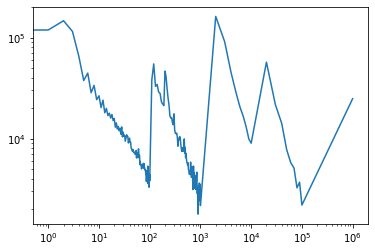

In [60]:
df.client_sum_group.value_counts().sort_index().plot()
plt.xscale('log')
plt.yscale('log')

# Case examle with sum_of_clients = 73

/Users/lukewyman/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


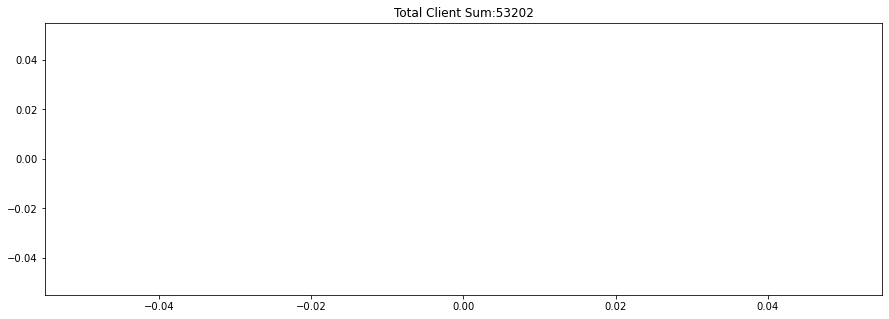

In [202]:
sum_of_clients = 53202
num_bins = sum_of_clients+1

test = df.loc[df.client_sum_group==sum_of_clients]

a, b = 1, sum_of_clients+1

plt.figure(figsize=(15,5))
plt.hist(test.num_clients, bins=np.linspace(a, b, num_bins),
         density=True, edgecolor='black')
plt.title("Total Client Sum:" + str(sum_of_clients))
plt.show()

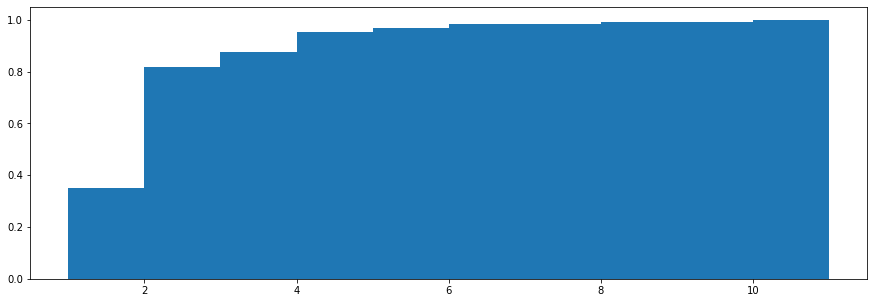

In [187]:
plt.figure(figsize=(15,5))
pds, bins, patches = plt.hist(test.num_clients, bins=np.linspace(a, b, num_bins), cumulative=True, density=True)

# print the list of probability densities
for i in range(len(pds)):
    pds[i] = round(pds[i], 3)

plt.show()

In [181]:
# probability that an observation is greater than or equal to 1, 2, ... sum_of_clients
probs = list(1-pds)
probs.insert(0, 1)
probs.pop(-1)
probs = np.array(probs)

bins = list(bins)
for i in range(len(bins)):
    bins[i] = int(i)
bins.pop(0)
bins = np.array(bins)

prob_map = pd.DataFrame({'num_clients': bins, 'prob_obs_num_clients': probs})
prob_map

,num_clients,prob_obs_num_clients
0,1,1.000
1,2,0.733


In [64]:
testcase = test.loc[test.index=='effusedprankle.com']
testcase

,day,num_clients,num_responses,num_shieldid,num_dns_qname,rank,created,updated,expires,whois,registration_period,client_sum_group
dns_qdomainname,,,,,,,,,,,,
effusedprankle.com,2022-10-01,4,144,2,1,NaN,2022-02-27,2022-02-27,2023-02-27,whois.pananames.com,365,73
effusedprankle.com,2022-10-02,4,360,2,1,NaN,2022-02-27,2022-02-27,2023-02-27,whois.pananames.com,365,73
effusedprankle.com,2022-10-03,26,623,4,1,NaN,2022-02-27,2022-02-27,2023-02-27,whois.pananames.com,365,73
effusedprankle.com,2022-10-04,20,840,4,1,NaN,2022-02-27,2022-02-27,2023-02-27,whois.pananames.com,365,73
effusedprankle.com,2022-10-05,16,600,2,1,NaN,2022-02-27,2022-02-27,2023-02-27,whois.pananames.com,365,73
effusedprankle.com,2022-10-11,2,24,2,1,NaN,2022-02-27,2022-02-27,2023-02-27,whois.pananames.com,365,73
effusedprankle.com,2022-10-21,1,12,1,1,NaN,2022-02-27,2022-02-27,2023-02-27,whois.pananames.com,365,73


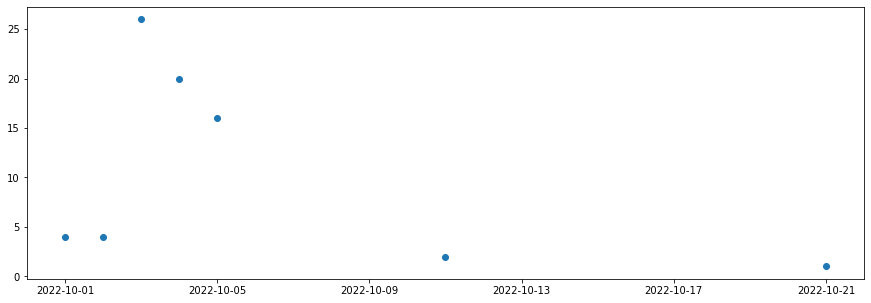

In [65]:
plt.figure(figsize=(15,5))
plt.scatter(x=testcase.day, y=testcase.num_clients)
plt.show()

<img src="spam_example1.png" width="800">

## Create a column called 'prob_obs_num_clients'

In [66]:
import time

start_time = time.time()

# drop the domains that are very large
df = df[df.client_sum_group != 0]

# list the sum groups created from our grouping_values function
client_sum_group_list = list(np.sort(df.client_sum_group.unique()))

# loop over each client_sum_group
for group in client_sum_group_list:
    # empty dictionary
    client_dict = {}
    # slice the df to sum group
    case = df.loc[df.client_sum_group==group]
    # create the number of bins so we get discrete bins
    num_bins = case.num_clients.max()
    # cumulative distribution of the empirical observations
    pds, bins = np.histogram(case.num_responses, bins=num_bins, density=True)
    # calculate the cumulative distribution function (CDF)
    pds = np.cumsum(pds)
    # list the probability of a value being greater than or equal to observed value
    probs = list(1-pds)
    probs.insert(0, 1)
    probs.pop(-1)
    probs = np.array(probs)
    # list the integer bin values
    bins = list(bins)
    for i in range(len(bins)):
        bins[i] = int(i)
    bins.pop(0)
    bins = np.array(bins)
    # client dictionary
    client_dict = dict(zip(bins, probs))
    # replace the values in the 'prob_obs_num_clients' column with dictionary values
    df.loc[df['client_sum_group'] == group, 'prob_obs_num_clients'] = case['num_clients'].map(client_dict)
    
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 2.8642101287841797 seconds


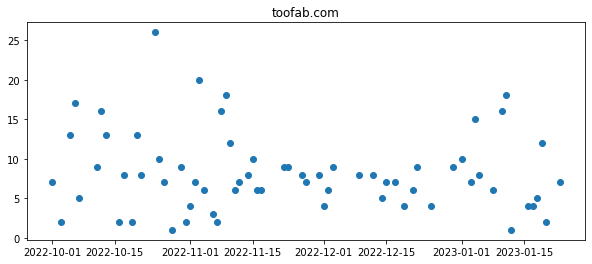

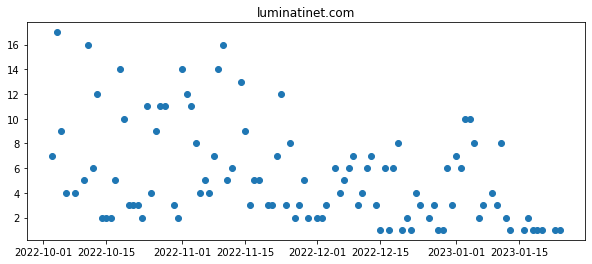

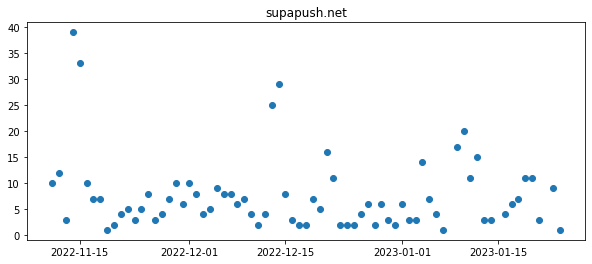

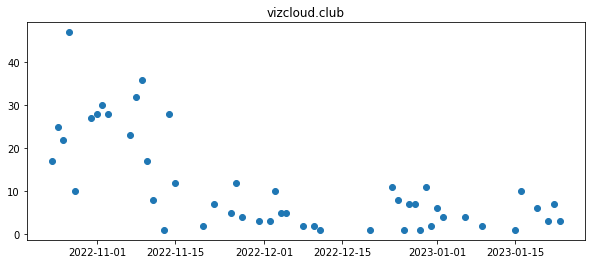

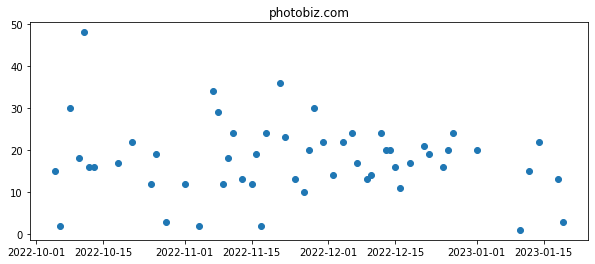

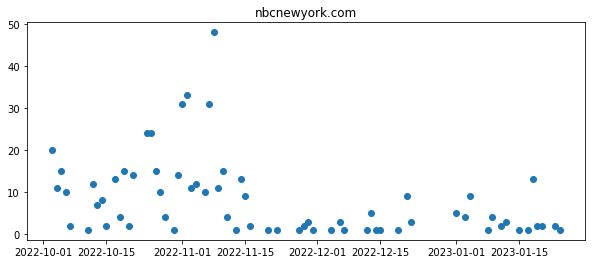

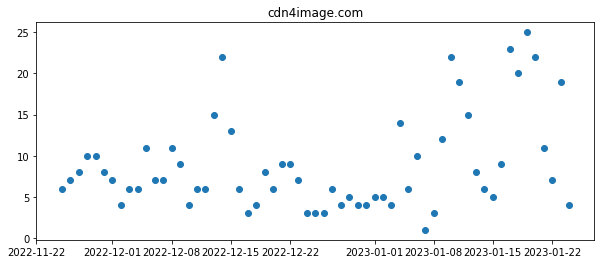

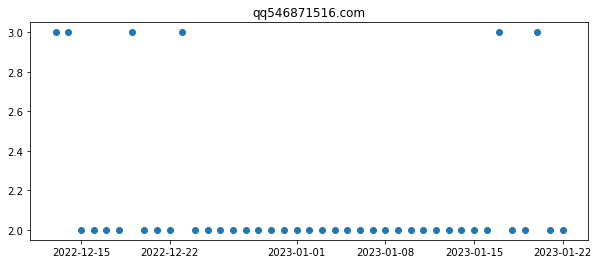

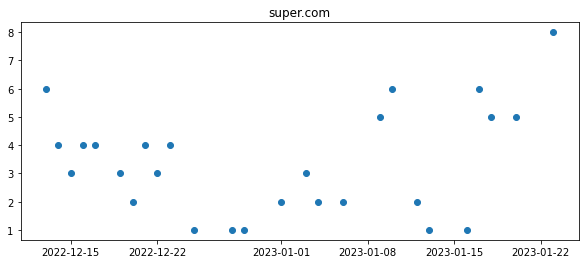

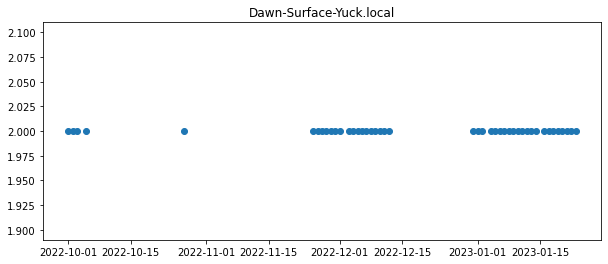

In [67]:
day = '2023-1-1'
rs = list(df.loc[(df.day==day)].sort_values(by='prob_obs_num_clients').head(10).index)
for i in rs:
    testcase = df.loc[df.index==i]
    plt.figure(figsize=(10,4))
    plt.title(i)
    plt.scatter(x=testcase.day, y=testcase.num_clients)
    plt.show()

In [68]:
df.loc[(df.prob_obs_num_clients<=.001)].client_sum_group.value_counts().sort_values()

Series([], Name: client_sum_group, dtype: int64)

In [69]:
df.prob_obs_num_clients.sort_values().head(5)

dns_qdomainname
youltube.biz         0.948712
undark.org           0.948767
rampup.store         0.949077
rampup.store         0.949187
kminnovations.net    0.949287
Name: prob_obs_num_clients, dtype: float64

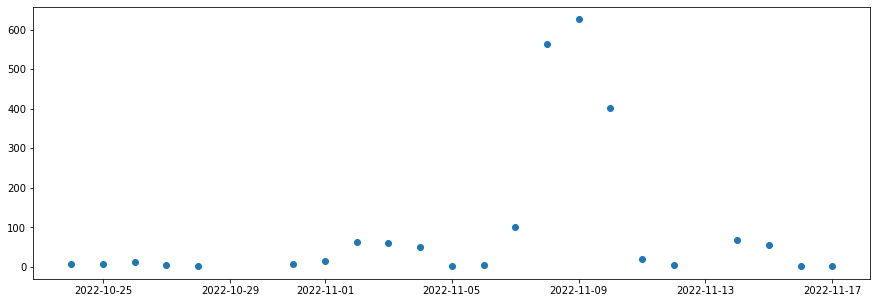

In [70]:
testcase = df.loc[df.index=='prreqcroab.icu']
plt.figure(figsize=(15,5))
plt.scatter(x=testcase.day, y=testcase.num_clients, )
plt.show()

<img src="spam_example2.png" width="800">

# Create a column called 'prob_obs_num_responses'

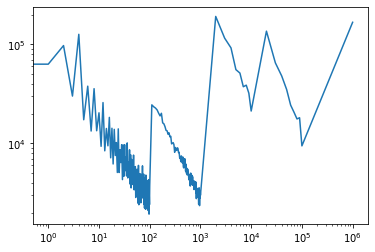

In [71]:
grouped = df.groupby('dns_qdomainname')['num_responses'].transform('sum').apply(lambda x: grouping_values(x))

# add the new column to the DataFrame
df['response_sum_group'] = grouped

df.response_sum_group.value_counts().sort_index().plot()
plt.xscale('log')
plt.yscale('log')

In [72]:
import time

start_time = time.time()

# drop the domains that are very large
df = df[df.response_sum_group != 0]

# list the sum groups created from our grouping_values function
response_sum_group_list = list(np.sort(df.response_sum_group.unique()))

# loop over each response_sum_group
for group in response_sum_group_list:
    # empty dictionary
    response_dict = {}
    # slice the df to sum group
    case = df.loc[df.response_sum_group==group]
    # create the number of bins so we get discrete bins
    num_bins = case.num_responses.max()
    # cumulative distribution of the empirical observations
    pds, bins = np.histogram(case.num_responses, bins=num_bins, density=True)
    # calculate the cumulative distribution function (CDF)
    pds = np.cumsum(pds)
    # list the probability of a value being greater than or equal to observed value
    probs = list(1-pds)
    probs.insert(0, 1)
    probs.pop(-1)
    probs = np.array(probs)
    # list the integer bin values
    bins = list(bins)
    for i in range(len(bins)):
        bins[i] = int(i)
    bins.pop(0)
    bins = np.array(bins)
    # response dictionary
    response_dict = dict(zip(bins, probs))
    # replace the values in the 'prob_obs_num_responses' column with dictionary values
    df.loc[df['response_sum_group'] == group, 'prob_obs_num_responses'] = case['num_responses'].map(response_dict)
    
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 4.124385118484497 seconds


In [73]:
df.prob_obs_num_responses.sort_values().head(5)

dns_qdomainname
ventasreit.com            -0.072645
chamberphl.com            -0.072645
teamcpg.com               -0.072645
robertmondaviwinery.com   -0.072645
robertscentre.com         -0.072645
Name: prob_obs_num_responses, dtype: float64

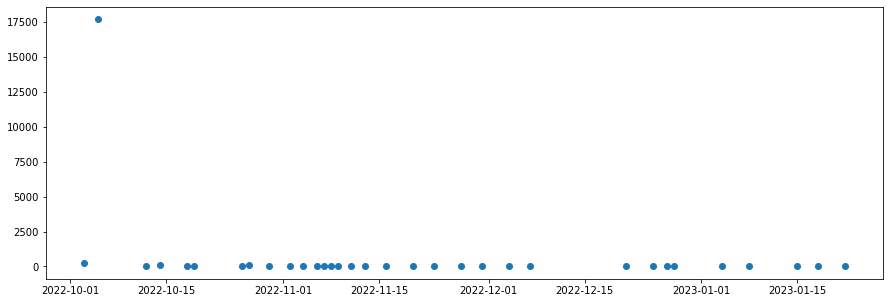

In [74]:
testcase = df.loc[df.index=='getrevue.co']
plt.figure(figsize=(15,5))
plt.scatter(x=testcase.day, y=testcase.num_responses)
plt.show()

# Create a column called 'prob_obs_num_shieldids'

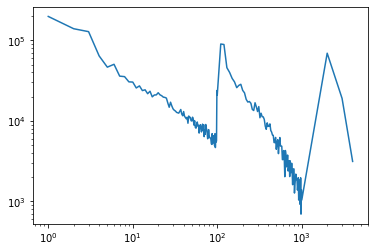

In [75]:
grouped = df.groupby('dns_qdomainname')['num_shieldid'].transform('sum').apply(lambda x: grouping_values(x))

# add the new column to the DataFrame
df['shieldid_sum_group'] = grouped

df.shieldid_sum_group.value_counts().sort_index().plot()
plt.xscale('log')
plt.yscale('log')

In [76]:
import time

start_time = time.time()

# drop the domains that are very large
df = df[df.shieldid_sum_group != 0]

# list the sum groups created from our grouping_values function
shieldid_sum_group_list = list(np.sort(df.shieldid_sum_group.unique()))

# loop over each shieldid_sum_group
for group in shieldid_sum_group_list:
    # empty dictionary
    shieldid_dict = {}
    # slice the df to sum group
    case = df.loc[df.shieldid_sum_group==group]
    # create the number of bins so we get discrete bins
    num_bins = case.num_shieldid.max()
    # cumulative distribution of the empirical observations
    pds, bins = np.histogram(case.num_responses, bins=num_bins, density=True)
    # calculate the cumulative distribution function (CDF)
    pds = np.cumsum(pds)
    # list the probability of a value being greater than or equal to observed value
    probs = list(1-pds)
    probs.insert(0, 1)
    probs.pop(-1)
    probs = np.array(probs)
    # list the integer bin values
    bins = list(bins)
    for i in range(len(bins)):
        bins[i] = int(i)
    bins.pop(0)
    bins = np.array(bins)
    # shieldid dictionary
    shieldid_dict = dict(zip(bins, probs))
    # replace the values in the 'prob_obs_num_shieldids' column with dictionary values
    df.loc[df['shieldid_sum_group'] == group, 'prob_obs_num_shieldids'] = case['num_shieldid'].map(shieldid_dict)
    
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 3.0242769718170166 seconds


In [77]:
df.prob_obs_num_shieldids.sort_values().head(10)

dns_qdomainname
scotthyoung.com                    0.997650
scotthyoung.com                    0.997650
musicradar.com                     0.997650
newrepublic.com                    0.997657
sharepoint-mil.us                  0.997659
khou.com                           0.997659
smartsites.com                     0.997659
site-static.com                    0.997659
sustentabilidadmercadolibre.com    0.997659
latest-hairstyles.com              0.997659
Name: prob_obs_num_shieldids, dtype: float64

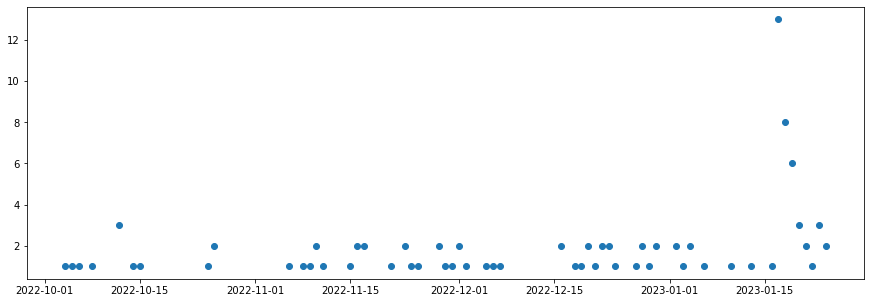

In [78]:
testcase = df.loc[df.index=='cntraveller.in']
plt.figure(figsize=(15,5))
plt.scatter(x=testcase.day, y=testcase.num_shieldid)
plt.show()

In [79]:
df.to_csv('dfmergedprobs.csv')

In [80]:
df['factor_probs'] = df.prob_obs_num_clients*df.prob_obs_num_responses*df.prob_obs_num_shieldids

In [81]:
l = df.sort_values(by='factor_probs').head(10000)
l = list(l.index.unique())

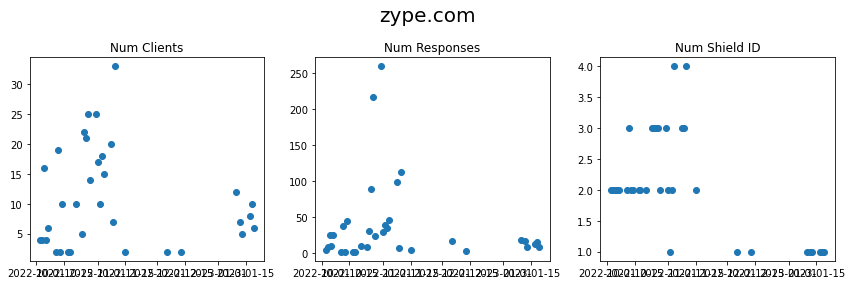

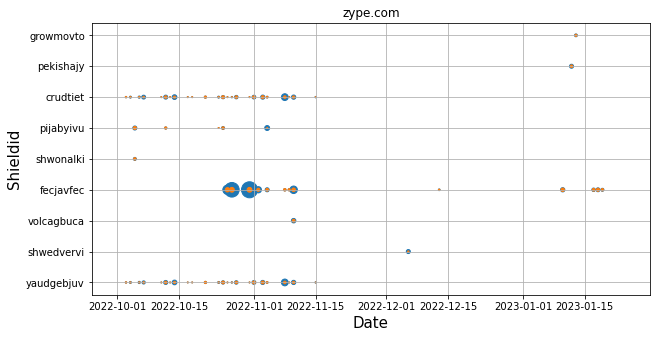

In [82]:
rs = random.sample(l,1)
rs = ['zype.com']
test=df.loc[df.index==rs[0]]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(test.day, test.num_clients)
axs[0].set_title('Num Clients')

axs[1].scatter(test.day, test.num_responses)
axs[1].set_title('Num Responses')

axs[2].scatter(test.day, test.num_shieldid)
axs[2].set_title('Num Shield ID')

plt.suptitle(str(rs[0]), fontsize=20)
plt.tight_layout()
plt.show()

def get_domain_case_new(data, domain_name):    
    
    datatemp = data.loc[data.dns_qdomainname==domain_name]
    
    # df1 sums by domain name and day
    df1 = datatemp.groupby(by=['dns_qdomainname','day','shieldid']).sum()

    # df2 counts unique query names by domain name and day
    df2 = datatemp.groupby(by=['dns_qdomainname','day','shieldid'])['dns_qname'].nunique()
    df2 = pd.DataFrame(df2)
    df2.rename(columns={'dns_qname': 'num_dns_qname'}, inplace=True)

    # Concatenate df1 and df2 into df
    domain_case_new = pd.concat([df1, df2], axis=1)
    domain_case_new.reset_index(level=1, inplace=True)
    domain_case_new.reset_index(level=1, inplace=True)
    
    from itertools import product

    # Create lists of all unique values in columns 
    l1 = [domain_name]
    l2 = list(data.day.unique())
    l3 = list(domain_case_new.shieldid.unique())
    l4 = [0]
    l5 = [0]
    l6 = [0]

    _ = pd.DataFrame(list(product(l1, l2, l3, l4, l5, l6)), columns=['dns_qdomainname', 'day', 'shieldid', 'num_clients', 'num_responses', 'num_dns_qname'])
    _.set_index(list(_)[0], inplace=True)

    domain_case_new = pd.concat([domain_case_new, _])

    domain_case_new = domain_case_new.sort_values('day')

    return domain_case_new
domain_name = rs[0]
domain_case_new = get_domain_case_new(data, domain_name)

# Plot
plt.figure(figsize=(10,5))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Shieldid', fontsize=15)
plt.title(domain_name)
plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_responses)
plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_clients)
plt.grid(axis='both')

In [83]:
df.loc[(df.index.isin(l))&((df['rank']>=10000)|(df['rank'].isna()))].index.nunique()/df.loc[(df.index.isin(l))].index.nunique()

0.9892

In [131]:
AgglomerativeClustering?

,day,num_clients,num_responses,num_shieldid,num_dns_qname,rank,created,updated,expires,whois,registration_period,client_sum_group,prob_obs_num_clients,response_sum_group,prob_obs_num_responses,shieldid_sum_group,prob_obs_num_shieldids,factor_probs
dns_qdomainname,,,,,,,,,,,,,,,,,,
*google.com,2022-10-02,1,2,1,1,NaN,NaT,NaT,NaT,NaN,0,31,1.000000,690,0.940904,22,1.000000,0.940904
*google.com,2022-10-03,1,2,1,1,NaN,NaT,NaT,NaT,NaN,0,31,1.000000,690,0.940904,22,1.000000,0.940904
*google.com,2022-10-04,1,2,1,1,NaN,NaT,NaT,NaT,NaN,0,31,1.000000,690,0.940904,22,1.000000,0.940904
*google.com,2022-10-10,1,1,1,1,NaN,NaT,NaT,NaT,NaN,0,31,1.000000,690,1.000000,22,1.000000,1.000000
*google.com,2022-10-11,3,115,2,1,NaN,NaT,NaT,NaT,NaN,0,31,0.997453,690,0.019642,22,0.999916,0.019590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzzquil.com,2022-11-03,2,2,2,1,NaN,2011-01-07,2011-01-07,2023-01-07,whois.corporatedomains.com,4383,16,0.999222,23,0.744536,9,0.999932,0.743906
zzzquil.com,2022-11-07,6,10,2,1,NaN,2011-01-07,2011-01-07,2023-01-07,whois.corporatedomains.com,4383,16,0.999222,23,0.057347,9,0.999932,0.057298
zzzquil.com,2022-11-14,2,4,2,1,NaN,2011-01-07,2011-01-07,2023-01-07,whois.corporatedomains.com,4383,16,0.999222,23,0.363083,9,0.999932,0.362776


In [207]:
a = df.groupby('dns_qdomainname')['num_clients'].transform('sum').sort_values()
parts = np.array_split(a, 250)
parts

[dns_qdomainname
 maglutainc.com              1
 amoxicillin.best            1
 amoxicillin.business        1
 amoxicillin.company         1
 amoxicillin.email           1
                            ..
 sankeyouzi.com              1
 doctor-plague.com           1
 infrastructure.institute    1
 sanluisrassini.com          1
 sanluisvalleyhealth.org     1
 Name: num_clients, Length: 11205, dtype: int64,
 dns_qdomainname
 hdtune.com                    1
 theniemannbest.com            1
 doctolib.de                   1
 doctolib.fr                   1
 thenicholson.com              1
                              ..
 momsmeet.com                  1
 flamehearts.co.jp             1
 mon-stage-en-argentine.com    1
 mon-terrassement.com          1
 mon.gov.ru                    1
 Name: num_clients, Length: 11205, dtype: int64,
 dns_qdomainname
 mon.gov.ua               1
 ust.com                  1
 richgirls.shop           1
 ussv.club                1
 ussupply.com             1
       

In [225]:
lst = np.unique([max(part) for part in parts])

array([     1,      2,      3,      4,      5,      6,      7,      8,
            9,     10,     11,     12,     13,     14,     15,     16,
           17,     18,     19,     20,     21,     22,     23,     24,
           25,     26,     27,     28,     29,     30,     31,     32,
           33,     35,     36,     37,     38,     39,     40,     41,
           43,     44,     45,     47,     48,     50,     51,     53,
           55,     56,     58,     59,     61,     63,     64,     66,
           68,     71,     73,     75,     77,     79,     81,     83,
           86,     89,     91,     94,     97,    100,    103,    105,
          108,    112,    115,    116,    117,    119,    122,    125,
          129,    132,    135,    138,    142,    146,    150,    154,
          158,    162,    167,    172,    177,    183,    188,    193,
          198,    199,    200,    201,    203,    206,    210,    212,
          215,    220,    224,    230,    234,    240,    247,    253,
      

In [235]:
import bisect
lst = np.unique([max(part) for part in parts])

def find_closest_neighbor(lst, x):
    index = bisect.bisect_left(lst, x)
    if index == 0:
        return lst[0]
    if index == len(lst):
        return lst[-1]
    before = lst[index - 1]
    after = lst[index]
    if after - x < x - before:
        return after
    else:
        return before

In [245]:
grouped = a.apply(lambda x: find_closest_neighbor(lst, x))

# add the new column to the DataFrame
df['client_sum_group'] = grouped

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [238]:
def find_closest_neighbor(x, lst):
    # Convert the list to a numpy array
    arr = np.array(lst)
    # Find the index of the element in the array that is closest to x
    idx = (np.abs(arr - x)).argmin()
    # Return the element in the array that is closest to x
    return arr[idx]

In [244]:
find_closest_neighbor(0,lst)

1